In [57]:
# Standard Library Imports
import warnings

# Third-Party Imports
import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from pandas.api.types import is_numeric_dtype, is_string_dtype
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from scipy.stats import boxcox, ks_2samp, normaltest, shapiro, yeojohnson, kstest
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor, make_column_transformer
from sklearn.ensemble import (AdaBoostRegressor, ExtraTreesRegressor,
                              GradientBoostingRegressor,
                              HistGradientBoostingRegressor,
                              RandomForestRegressor, StackingRegressor,
                              VotingRegressor)
from sklearn.feature_selection import (RFECV, SelectKBest,
                                       mutual_info_regression, f_regression,VarianceThreshold)
from sklearn.impute import KNNImputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import (ElasticNet, Lasso, LinearRegression,
                                  Ridge, RidgeCV)
from sklearn.metrics import (make_scorer, mean_squared_error, 
                             mean_squared_log_error, 
                             mean_absolute_error)
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,KFold, RepeatedKFold,
                                     StratifiedKFold, StratifiedShuffleSplit,
                                     cross_val_score, cross_validate,
                                     train_test_split, learning_curve,permutation_test_score)
from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.preprocessing import (FunctionTransformer, MinMaxScaler,
                                   OneHotEncoder, PolynomialFeatures,
                                   PowerTransformer, RobustScaler,
                                   StandardScaler, QuantileTransformer)
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Local Imports
from statsmodels.graphics.gofplots import qqplot


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
warnings.filterwarnings("ignore", category=UserWarning)

SEED = 42

In [58]:
# Load data
train = pd.read_csv('data/train.csv',index_col=0)
test = pd.read_csv('data/test.csv',index_col=0)
sub = pd.read_csv('data/sample_submission.csv',index_col=0)

# Understanding Abalone Dataset Features

- Sex: This feature represents the gender of the abalone,categorized as male (M), female (F), or infant (I).

- Length: The length feature denotes the longest measurement of the abalone shell, from the apex to the base, measured in millimeters.

- Diameter: Diameter represents the measurement of the abalone shell perpendicular to its length, also measured in millimeters.

- Height: This feature signifies the height of the abalone shell, measured perpendicular to the plane formed by the length and diameter, in millimeters.

- Whole weight: Whole weight indicates the total weight of the abalone, encompassing both the meat and the shell, measured in grams.

- Whole weight.1 (Shucked weight): This feature represents the weight of the abalone meat only, measured in grams. It indicates the amount of meat extracted from the shell.

- Whole weight.2 (Viscera weight): Viscera weight signifies the weight of the abalone gut after bleeding, measured in grams.It provides insights into the weight of the internal organs of the abalone.

- Shell weight: This feature represents the weight of the abalone shell only, excluding the meat, measured in grams. It provides insights into the weight distribution between the shell and the edible portion of the abalone.

- Rings: Rings signify the number of rings present on the abalone shell, serving as an indicator of the abalone's age.

In [59]:
def rename_and_lowercase(df):
    """Rename columns and convert them to lowercase"""
    df = df.copy()
    df = df.rename(columns = {'Whole weight.1':'shucked weight'})
    df = df.rename(columns = {'Whole weight.2':'viscera weight'})
    df = df.rename(columns=lambda x: x.lower().replace(' ', '_'))
    return df

train = rename_and_lowercase(train)
test = rename_and_lowercase(test)

train.columns, test.columns

(Index(['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight',
        'viscera_weight', 'shell_weight', 'rings'],
       dtype='object'),
 Index(['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight',
        'viscera_weight', 'shell_weight'],
       dtype='object'))

In [60]:
# # function to calculate univariate stats like pandas describe method
# def feature_creation(df):
#     df = df.copy()
#     df['length_diameter_ratio'] = df['length'] / df['diameter']
#     df['height_diameter_ratio'] = df['height'] / df['diameter']
#     df['volume'] = (4/3) * np.pi * (df['length']/2) * (df['diameter']/2) * (df['height']/2)
#     df['shell_thickness_to_length'] = (df['whole_weight'] - df['shucked_weight']) / df['length']
#     df['shell_thickness_to_diameter'] = (df['whole_weight'] - df['shucked_weight']) / df['diameter']
#     return df


# train = feature_creation(train)
# test = feature_creation(test)

# train.columns, test.columns

# 1 - EDA - Exploratory Analysis

## 1.1 - Summary Statistics

In [61]:
def generate_summary_statistics(data):
  
    summary_table = pd.DataFrame(data.dtypes, columns=['dtypes'])
    summary_table['Missing'] = data.isnull().sum()
    summary_table['Unique'] = data.nunique()
    summary_table['Count'] = data.count()
    summary_table['Duplicated'] = data.duplicated().sum()
    summary_table['zero_values'] = data.isin([0]).sum()
    
    
    return summary_table

In [62]:
generate_summary_statistics(train)

,dtypes,Missing,Unique,Count,Duplicated,zero_values
sex,object,0,3,90615,0,0
length,float64,0,157,90615,0,0
diameter,float64,0,126,90615,0,0
height,float64,0,90,90615,0,6
whole_weight,float64,0,3175,90615,0,0
shucked_weight,float64,0,1799,90615,0,0
viscera_weight,float64,0,979,90615,0,0
shell_weight,float64,0,1129,90615,0,0
rings,int64,0,28,90615,0,0


In [63]:
generate_summary_statistics(test)

,dtypes,Missing,Unique,Count,Duplicated,zero_values
sex,object,0,3,60411,0,0
length,float64,0,148,60411,0,0
diameter,float64,0,130,60411,0,0
height,float64,0,85,60411,0,2
whole_weight,float64,0,3037,60411,0,0
shucked_weight,float64,0,1747,60411,0,0
viscera_weight,float64,0,960,60411,0,0
shell_weight,float64,0,1089,60411,0,0


<div style="background-color: #343A1A; padding: 10px; border: 1px solid #ccc; border-radius: 5px;">
    <p>There are missing values in the dataset. The columns; <b>
    <ul>
    <li>height</li>
    <li>height_diameter_ratio</li>
    <li>volume</li>
    <li>shell_thickness_to_length</li>
    <li>shell_thickness_to_diameter</li>
<div>

## 1.2 - Univariate Analysis

In [64]:
# function to calculate univariate stats like pandas describe method
def univariate_stats(df):
    
    output_df = pd.DataFrame(columns=['Count', 'Missing', 'Unique', 'Dtype', 'IsNumeric', 'Mode', 'Mean', 'Min', '25%', 'Median', '75%', 'Max', 'Std', 'Skew', 'Kurt'])
    
    for col in df:
        if is_numeric_dtype(df[col]):
            output_df.loc[col] = [df[col].count(), df[col].isnull().sum(), df[col].nunique(), df[col].dtype, is_numeric_dtype(df[col]), df[col].mode().values[0], df[col].mean(), df[col].min(), df[col].quantile(.25), df[col].median(), df[col].quantile(.75), df[col].max(), df[col].std(), df[col].skew(), df[col].kurt() ]
        else:
            output_df.loc[col] = [df[col].count(), df[col].isnull().sum(), df[col].nunique(), df[col].dtype, is_numeric_dtype(df[col]), df[col].mode().values[0], '-', '-', '-', '-', '-', '-', '-', '-', '-' ]
    
    return output_df.sort_values(by=['IsNumeric', 'Unique'], ascending=False)

In [65]:
univariate_stats(train)

,Count,Missing,Unique,Dtype,IsNumeric,Mode,Mean,Min,25%,Median,75%,Max,Std,Skew,Kurt
whole_weight,90615,0,3175,float64,True,0.5805,0.789035,0.002,0.419,0.7995,1.0675,2.8255,0.457671,0.429316,-0.185136
shucked_weight,90615,0,1799,float64,True,0.096,0.340778,0.001,0.1775,0.33,0.463,1.488,0.204428,0.591973,0.284012
shell_weight,90615,0,1129,float64,True,0.24,0.225898,0.0015,0.12,0.225,0.305,1.005,0.130203,0.479092,0.096049
viscera_weight,90615,0,979,float64,True,0.1715,0.169422,0.0005,0.0865,0.166,0.2325,0.76,0.100909,0.476733,-0.203721
length,90615,0,157,float64,True,0.575,0.517098,0.075,0.445,0.545,0.6,0.815,0.118217,-0.732015,0.133364
diameter,90615,0,126,float64,True,0.45,0.401679,0.055,0.345,0.425,0.47,0.65,0.098026,-0.695236,0.000646
height,90615,0,90,float64,True,0.15,0.135464,0.0,0.11,0.14,0.16,1.13,0.038008,0.309975,13.454051
rings,90615,0,28,int64,True,9,9.696794,1,8.0,9.0,11.0,29,3.176221,1.204273,2.612934
sex,90615,0,3,object,False,I,-,-,-,-,-,-,-,-,-


**Note** : Volume, height_diameter_ratio, height,have some null values

In [66]:
univariate_stats(test)

,Count,Missing,Unique,Dtype,IsNumeric,Mode,Mean,Min,25%,Median,75%,Max,Std,Skew,Kurt
whole_weight,60411,0,3037,float64,True,0.5805,0.790062,0.002,0.4195,0.8015,1.07,2.8255,0.457591,0.435664,-0.165426
shucked_weight,60411,0,1747,float64,True,0.3485,0.341227,0.001,0.1785,0.329,0.4645,1.488,0.204221,0.593206,0.290172
shell_weight,60411,0,1089,float64,True,0.24,0.226125,0.0015,0.12,0.225,0.305,1.004,0.129826,0.468524,0.042671
viscera_weight,60411,0,960,float64,True,0.1715,0.169419,0.0005,0.0865,0.166,0.2325,0.6415,0.10072,0.476129,-0.204883
length,60411,0,148,float64,True,0.575,0.517428,0.075,0.45,0.545,0.6,0.8,0.117609,-0.734565,0.141789
diameter,60411,0,130,float64,True,0.45,0.401961,0.055,0.345,0.425,0.47,0.65,0.09747,-0.696312,0.004065
height,60411,0,85,float64,True,0.15,0.135751,0.0,0.11,0.14,0.16,1.095,0.038175,0.554506,17.693333
sex,60411,0,3,object,False,I,-,-,-,-,-,-,-,-,-


In [67]:
# list of numerical and categorical columns

numeric_cols = train.select_dtypes(exclude=['object']).columns.tolist()
categorical_cols = train.select_dtypes(include=['object']).columns.tolist()
target = 'rings'
numeric_cols_without_target = [col for col in numeric_cols if col != target]

numeric_cols, categorical_cols, numeric_cols_without_target

(['length',
  'diameter',
  'height',
  'whole_weight',
  'shucked_weight',
  'viscera_weight',
  'shell_weight',
  'rings'],
 ['sex'],
 ['length',
  'diameter',
  'height',
  'whole_weight',
  'shucked_weight',
  'viscera_weight',
  'shell_weight'])

In [68]:
# recursive elimination of features with cross validation
base_model = LGBMRegressor(force_col_wise=True,random_state=SEED)

min_features_to_select = 1

rfecv = RFECV(estimator=base_model, 
                step=1, 
                cv=KFold(n_splits=5, shuffle=True, random_state=SEED),
                scoring='neg_mean_squared_log_error',
                min_features_to_select=min_features_to_select,
                n_jobs=-1)

one_hot_encoded = pd.get_dummies(train[categorical_cols], prefix='sex')

train_encoded = pd.concat([train, one_hot_encoded], axis=1)

train_encoded = train_encoded.drop('sex', axis=1).drop('rings', axis=1)

print(train_encoded.columns)

rfecv.fit(train_encoded, train[target])

print(f"Optimal number of features: {rfecv.n_features_}")

Index(['length', 'diameter', 'height', 'whole_weight', 'shucked_weight',
       'viscera_weight', 'shell_weight', 'sex_F', 'sex_I', 'sex_M'],
      dtype='object')


[LightGBM] [Info] Total Bins 1337
[LightGBM] [Info] Number of data points in the train set: 90615, number of used features: 10
[LightGBM] [Info] Start training from score 9.696794
[LightGBM] [Info] Total Bins 1335
[LightGBM] [Info] Number of data points in the train set: 90615, number of used features: 9
[LightGBM] [Info] Start training from score 9.696794
[LightGBM] [Info] Total Bins 1333
[LightGBM] [Info] Number of data points in the train set: 90615, number of used features: 8
[LightGBM] [Info] Start training from score 9.696794
[LightGBM] [Info] Total Bins 1333
[LightGBM] [Info] Number of data points in the train set: 90615, number of used features: 8
[LightGBM] [Info] Start training from score 9.696794
Optimal number of features: 8


In [71]:
#features selected by RFECV
selected_features = train_encoded.columns[rfecv.support_]

print(f"Selected features: {selected_features}")

# feature removed by RFECV
removed_features = train_encoded.columns[~rfecv.support_]
print(f"Removed features: {removed_features}")


selected_features_numeric = [col for col in selected_features if col in numeric_cols_without_target]

selected_features_numeric

Selected features: Index(['length', 'diameter', 'height', 'whole_weight', 'shucked_weight',
       'viscera_weight', 'shell_weight', 'sex_I'],
      dtype='object')
Removed features: Index(['sex_F', 'sex_M'], dtype='object')


['length',
 'diameter',
 'height',
 'whole_weight',
 'shucked_weight',
 'viscera_weight',
 'shell_weight']

### Histograms

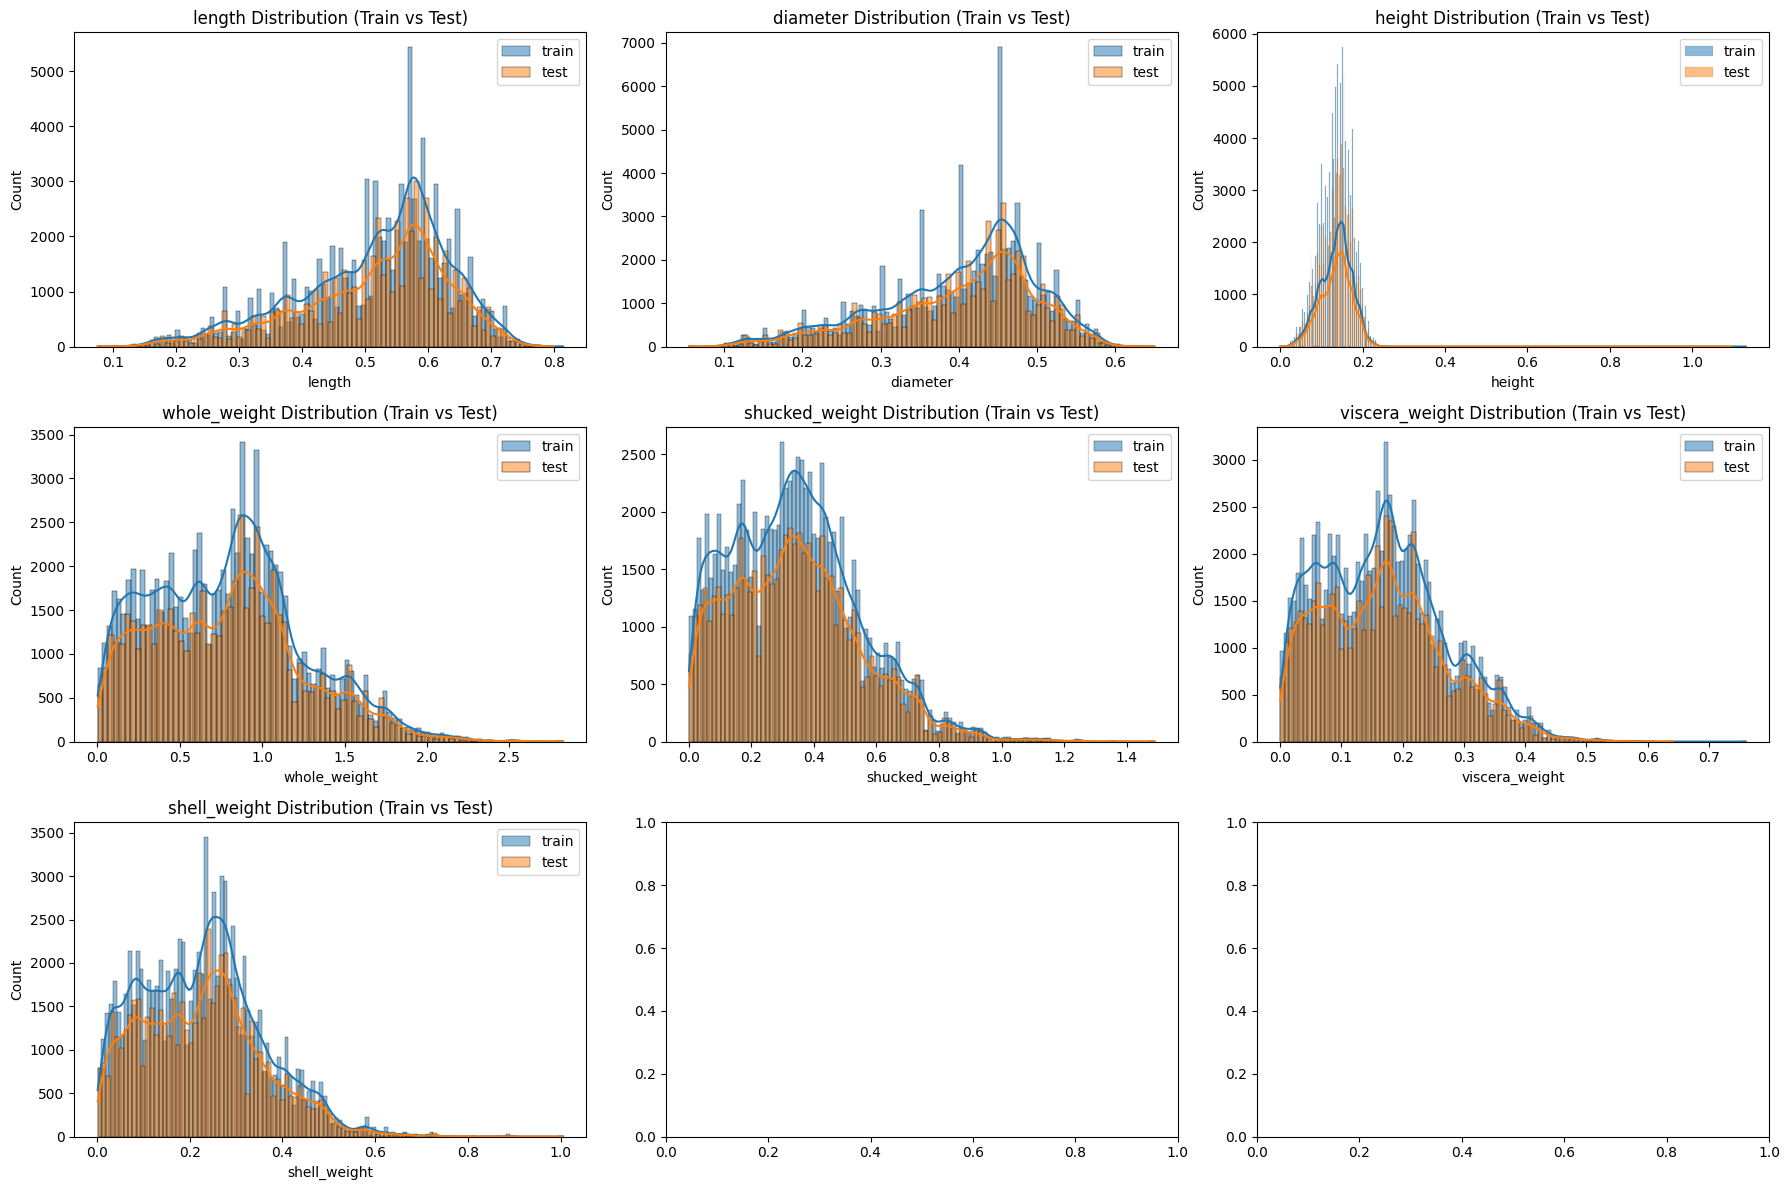

In [72]:
def plot_histograms(df_train, df_test, target_col, n_cols=3):
    n_rows = (len(df_train.columns) - 1) // n_cols + 1

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))

    axes = axes.flatten()

    for i, var_name in enumerate(df_train.columns.tolist()):
        
        if var_name != target_col:
            ax = axes[i]
       
            # plot histogram for each variable in train
            sns.histplot(df_train[var_name], kde=True, ax=ax, label='train')

            # plot histogram for each variable in test
            sns.histplot(df_test[var_name], kde=True, ax=ax, label='test')

        
        ax.set_title(f'{var_name} Distribution (Train vs Test)')
        ax.legend()

    plt.tight_layout()
    plt.show()

plot_histograms(train[selected_features_numeric], test, target, n_cols=3)

### Distributions

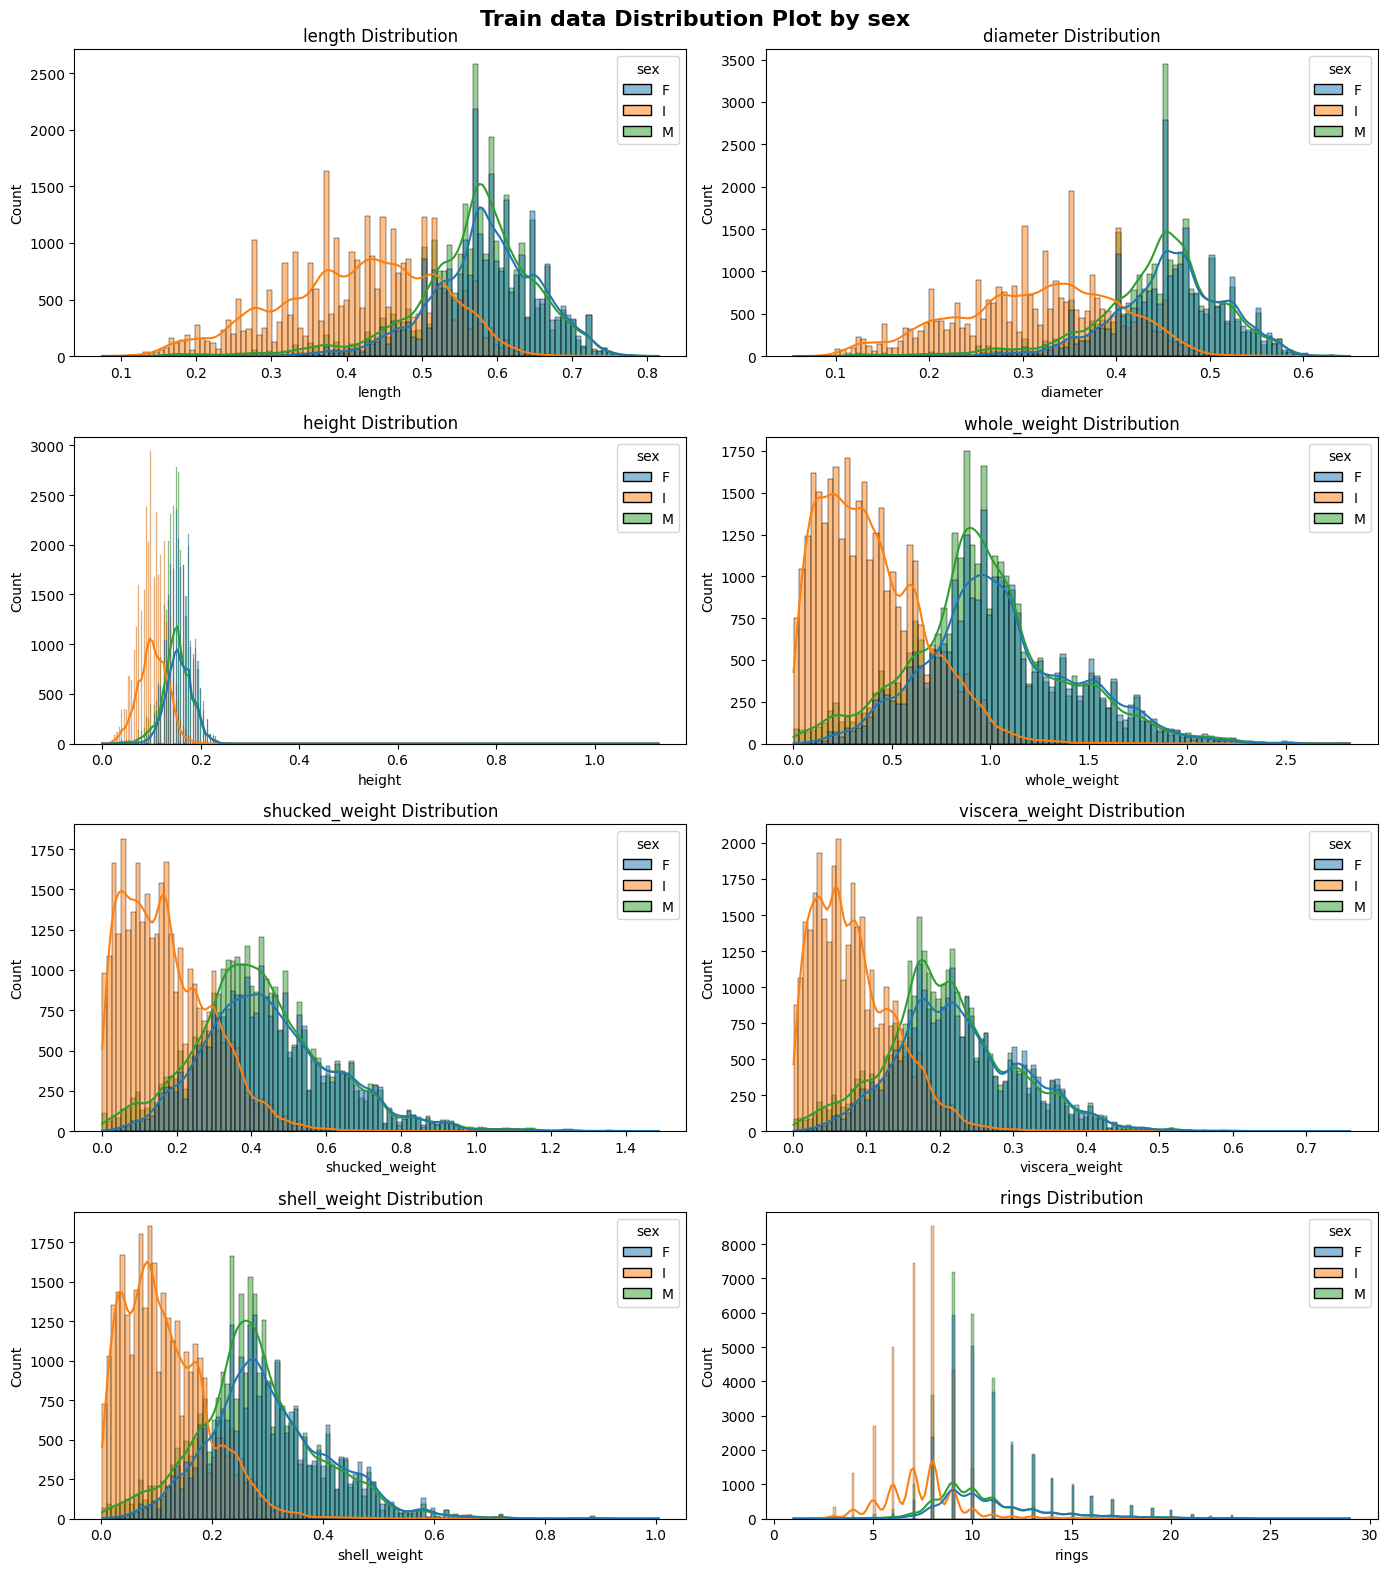

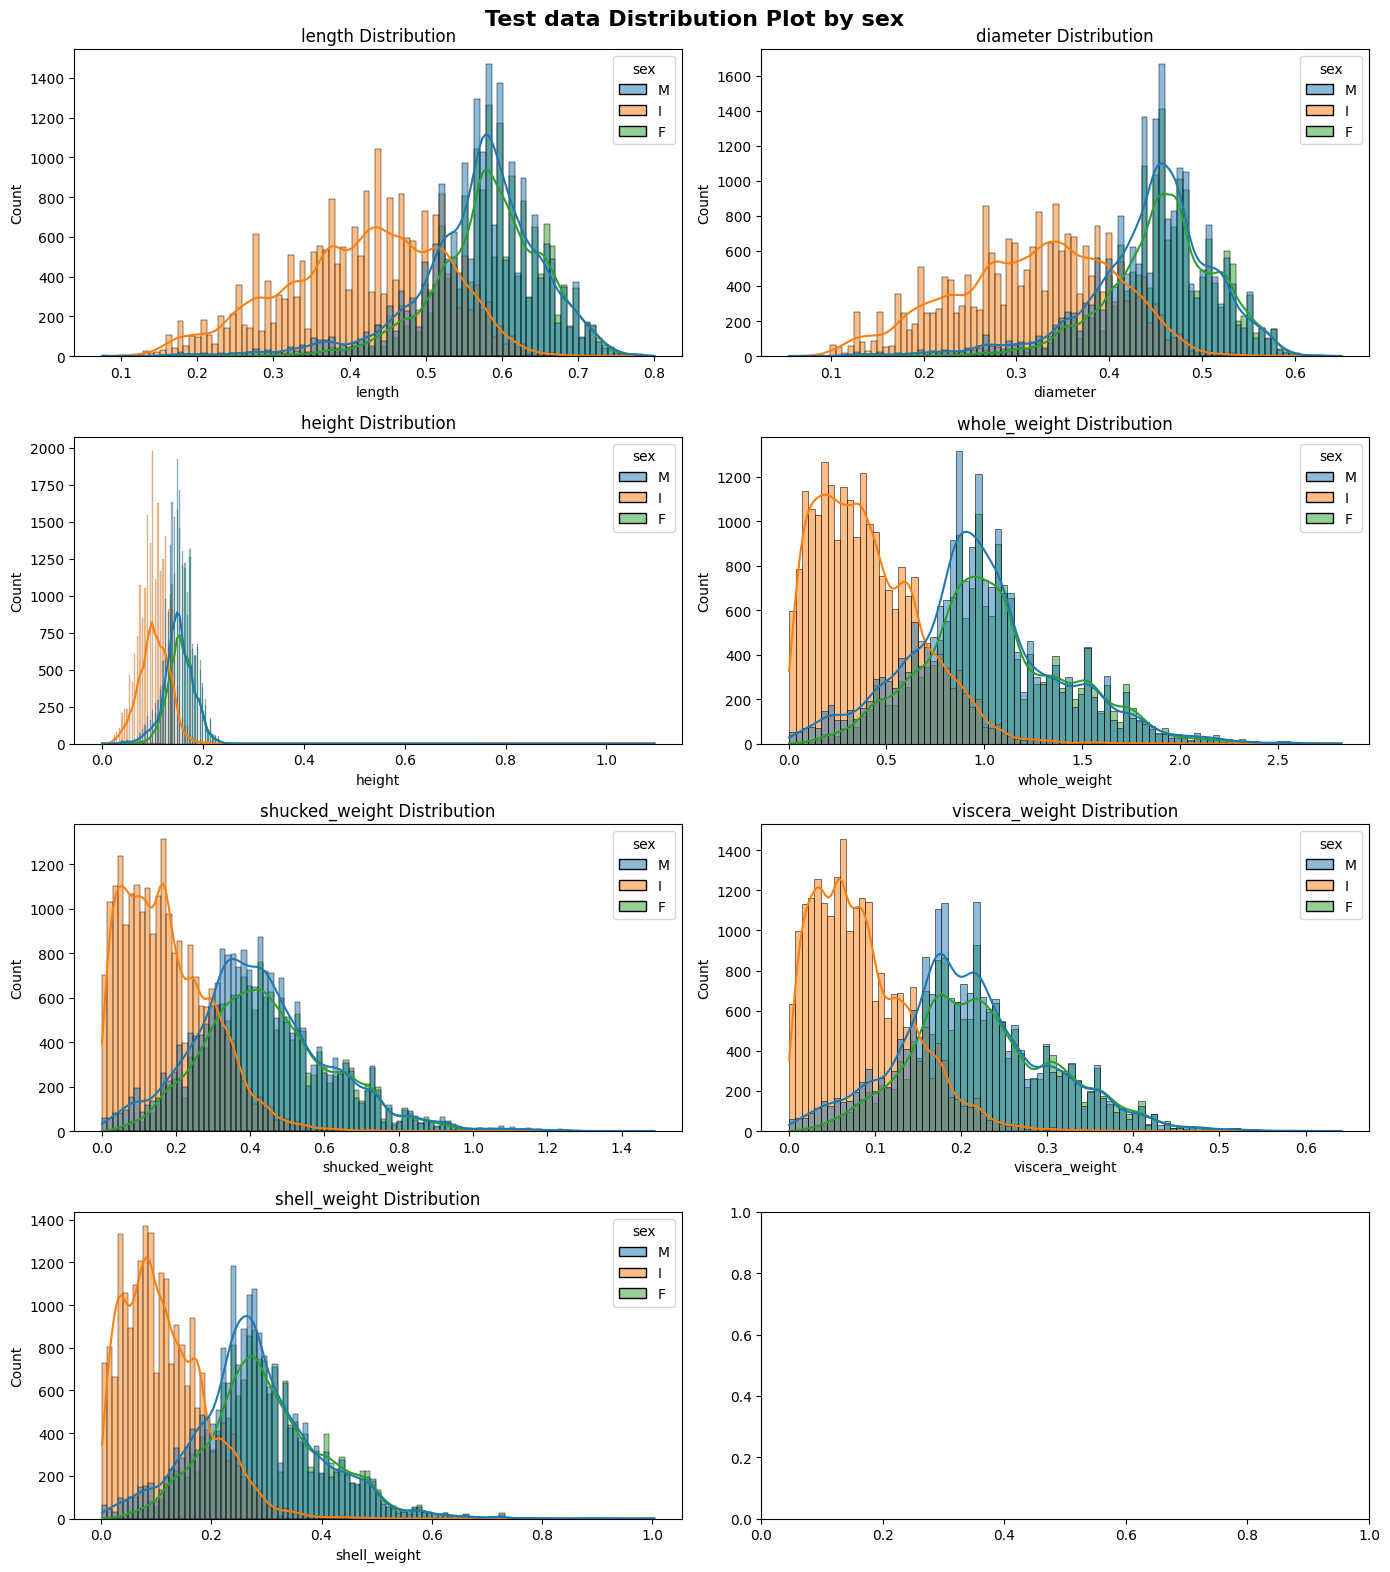

In [73]:
def plot_distributions(df, hue, title='', drop_cols=[]):
    
    cols = df.columns.drop([hue] + drop_cols)
    n_cols = 2
    n_rows = (len(cols) - 1) // n_cols + 1
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
    
    for i, var_name in enumerate(cols):
        row = i // n_cols
        col = i % n_cols
        
        ax = axes[row, col]
        sns.histplot(df, x=var_name, hue=hue, kde=True, ax=ax)
        ax.set_title(f'{var_name} Distribution')
    
    fig.suptitle(f'{title} Distribution Plot by {hue}', fontweight='bold', fontsize=16)
    plt.tight_layout()
    plt.show()
    
plot_distributions(train,hue='sex', title='Train data')
plot_distributions(test,hue='sex', title='Test data')

<div style="background-color: #343A1A; padding: 10px; border: 1px solid #ccc; border-radius: 5px;">
    
**Note:** 
<ul>
    <li>There is a big difference in distribution between I (infant) and adults (M or F). It almost like a binary variable, either is is infant or not</li>
    <li>Maybe test it feature engineering</li>
</ul>

</div>

In [74]:
# check if distributions of sex for "M" and "F" are statistically different
stat, p = ks_2samp(train['sex'].eq('M'),train['sex'].eq('F'))
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

# cannot transform sex into a binary variable as the distribution

stat=0.050, p=0.000
Different distribution (reject H0)


### Correlations

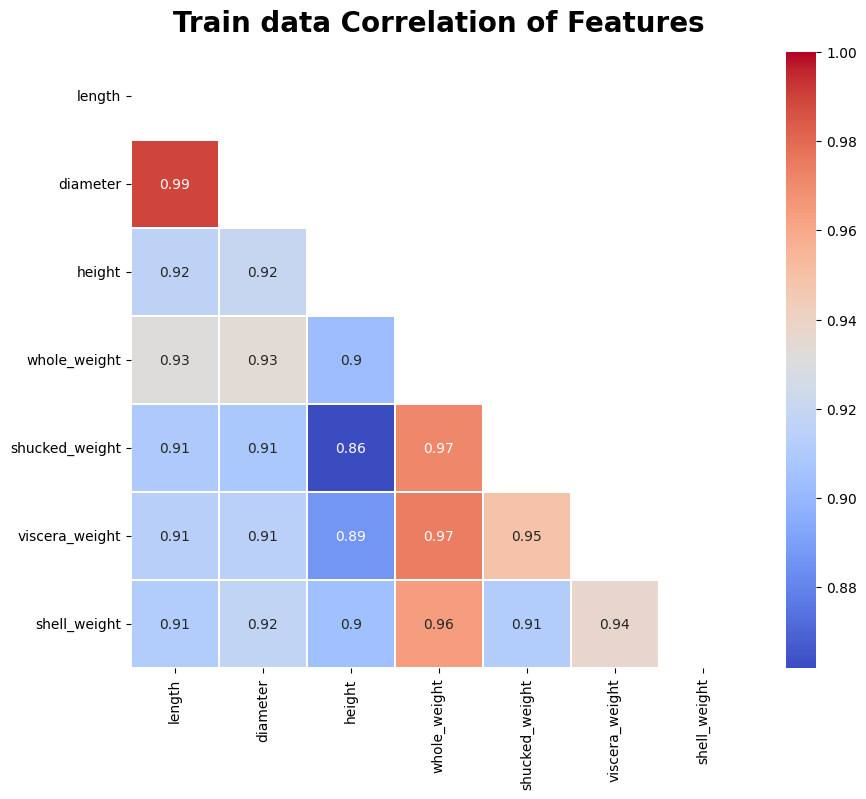

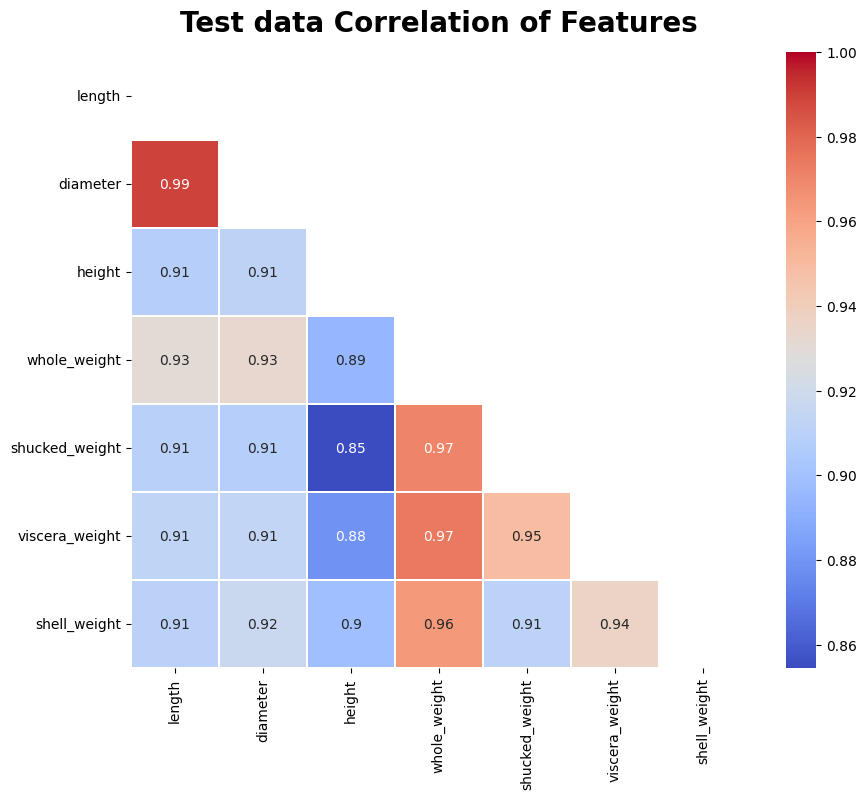

In [75]:
def plot_heatmap(df,title):
    
    mask = np.zeros_like(df.astype(float).corr())
    mask[np.triu_indices_from(mask)] = True
    
    plt.figure(figsize=(10, 8))
    
    plt.title(f'{title} Correlation of Features', fontweight='bold', y=1.02, size=20)
    
    sns.heatmap(df.astype(float).corr(),
                linewidths=0.1,
                vmax=1.0, 
                square=True, 
                cmap='coolwarm', 
                linecolor='white', 
                annot=True, 
                mask=mask)
    
plot_heatmap(train[selected_features_numeric], title='Train data')
plot_heatmap(test[selected_features_numeric], title='Test data')

<div style="background-color: #343A1A; padding: 10px; border: 1px solid #ccc; border-radius: 5px;">

**Notes**

<p>When all features are highly correlated, it can lead to multicollinearity in your model, which can make the model's estimates very sensitive to changes in the model. Here are a few strategies to handle this situation</p>

<ul>  
    <li><b>Feature Selection:</b> You can manually select a subset of your features based on domain knowledge or based on the correlation matrix</li>
    <li><b>Dimensionality Reduction:</b> Techniques like Principal Component Analysis (PCA) can be used to reduce the dimensionality of your data. PCA creates new uncorrelated variables that successively maximize variance</li>
    <li><b>Regularization:</b> Use a model that includes a penalty term for complexity in the loss function, such as Lasso or Ridge regression. These models can help to avoid overfitting by penalizing large coefficients</li>
    <li><b>Variance Inflation Factor (VIF):</b> Calculate the VIF for each variable, which measures how much the variance of the estimated regression coefficients are increased because of multicollinearity. If VIF is high for a variable, consider dropping it</li>
    <li><b>Combine Features:</b> If it makes sense in the context of your problem, you can combine correlated features into a single feature (for example, by taking an average)</li>
</ul>

</div>

In [76]:
# check which features are approximately normally distributed
def check_normality(df):
    for col in df.columns:
        if is_numeric_dtype(df[col]):
            print(f'{col} normality test results:')
            print(shapiro(df[col]))
            print(normaltest(df[col]))
            print("This distribution is approximately normal" if shapiro(df[col])[1] > 0.05 else "This distribution is not approximately normal")
            print('\n')
            
check_normality(train[selected_features_numeric])

length normality test results:
ShapiroResult(statistic=0.9585015177726746, pvalue=0.0)
NormaltestResult(statistic=6605.831769867752, pvalue=0.0)
This distribution is not approximately normal


diameter normality test results:
ShapiroResult(statistic=0.9590755701065063, pvalue=0.0)
NormaltestResult(statistic=6007.384380807614, pvalue=0.0)
This distribution is not approximately normal


height normality test results:
ShapiroResult(statistic=0.9756640791893005, pvalue=0.0)
NormaltestResult(statistic=19780.51596199518, pvalue=0.0)
This distribution is not approximately normal


whole_weight normality test results:
ShapiroResult(statistic=0.9759870767593384, pvalue=0.0)
NormaltestResult(statistic=2717.164607511156, pvalue=0.0)
This distribution is not approximately normal


shucked_weight normality test results:
ShapiroResult(statistic=0.9708635210990906, pvalue=0.0)
NormaltestResult(statistic=4796.649178696949, pvalue=0.0)
This distribution is not approximately normal


viscera_weight norm

In [77]:
# check skewness and kurtosis of the features with following 
#If the skewness is between -0.5 and 0.5, the data are fairly symmetrical.
#If the skewness is between -1 and -0.5 or between 0.5 and 1, the data are moderately skewed.
#If the skewness is less than -1 or greater than 1, the data are highly skewed.
def check_skewness(df):
    """
    Check skewness of numerical columns in a DataFrame and recommend transformation based on guidelines.

    Parameters:
    df (DataFrame): The DataFrame containing numerical columns.

    Returns:
    tuple: Three dictionaries, one containing column names needing transformation with negative skewness,
    one containing column names needing transformation with positive skewness,
    and one containing column names not needing transformation.
    """
    cols_need_transform_positive = {}
    cols_need_transform_negative = {}
    cols_no_transform = []

    for col in df.select_dtypes(include=[np.number]):
        skewness = df[col].skew()
        if -0.5 <= skewness <= 0.5:
            cols_no_transform.append(col)
        elif (-1 <= skewness < -0.5) or (0.5 < skewness <= 1):
            if skewness < 0:
                cols_need_transform_negative[col] = skewness
            else:
                cols_need_transform_positive[col] = skewness
    
    return cols_need_transform_positive, cols_need_transform_negative, cols_no_transform

# Example usage:
# Assuming 'df' is your DataFrame
cols_need_transform_positive, cols_need_transform_negative, cols_no_transform = check_skewness(train[selected_features_numeric])
print("Columns needing positive skewness transformation:", cols_need_transform_positive)
print("Columns needing negative skewness transformation:", cols_need_transform_negative)
print("Columns not needing transformation:", cols_no_transform)

Columns needing positive skewness transformation: {'shucked_weight': 0.5919732945442424}
Columns needing negative skewness transformation: {'length': -0.7320151933171148, 'diameter': -0.6952359660461651}
Columns not needing transformation: ['height', 'whole_weight', 'viscera_weight', 'shell_weight']


<div style="background-color: #343A1A; padding: 10px; border: 1px solid #ccc; border-radius: 5px;">

**Notes**

<p>If the distribution of your data is not normal, there are several strategies you can use to transform your data to be more normally distributed:</p>
<div>
<ul>
<li><b>Log Transformation:</b> This is useful when your data is skewed. It can help to reduce the skewness.</li>
<pre>
<code>
df['log_transformed'] = np.log(df['original_column'])
</code>
</pre>
<li><b>Square Root Transformation:</b> This is another method to reduce skewness. It's less strong than the log transformation.</li>
<pre>
<code>
df['sqrt_transformed'] = np.sqrt(df['original_column'])
</code>
</pre>

<li><b>Yeo-Johnson Transformation:</b> This is similar to Box-Cox, but it can be used with zero and negative values.</li>
<pre>
<code>
df['yeojohnson_transformed'], _ = stats.yeojohnson(df['original_column'])
</code>
</pre>
<ul>
</div>
</div>

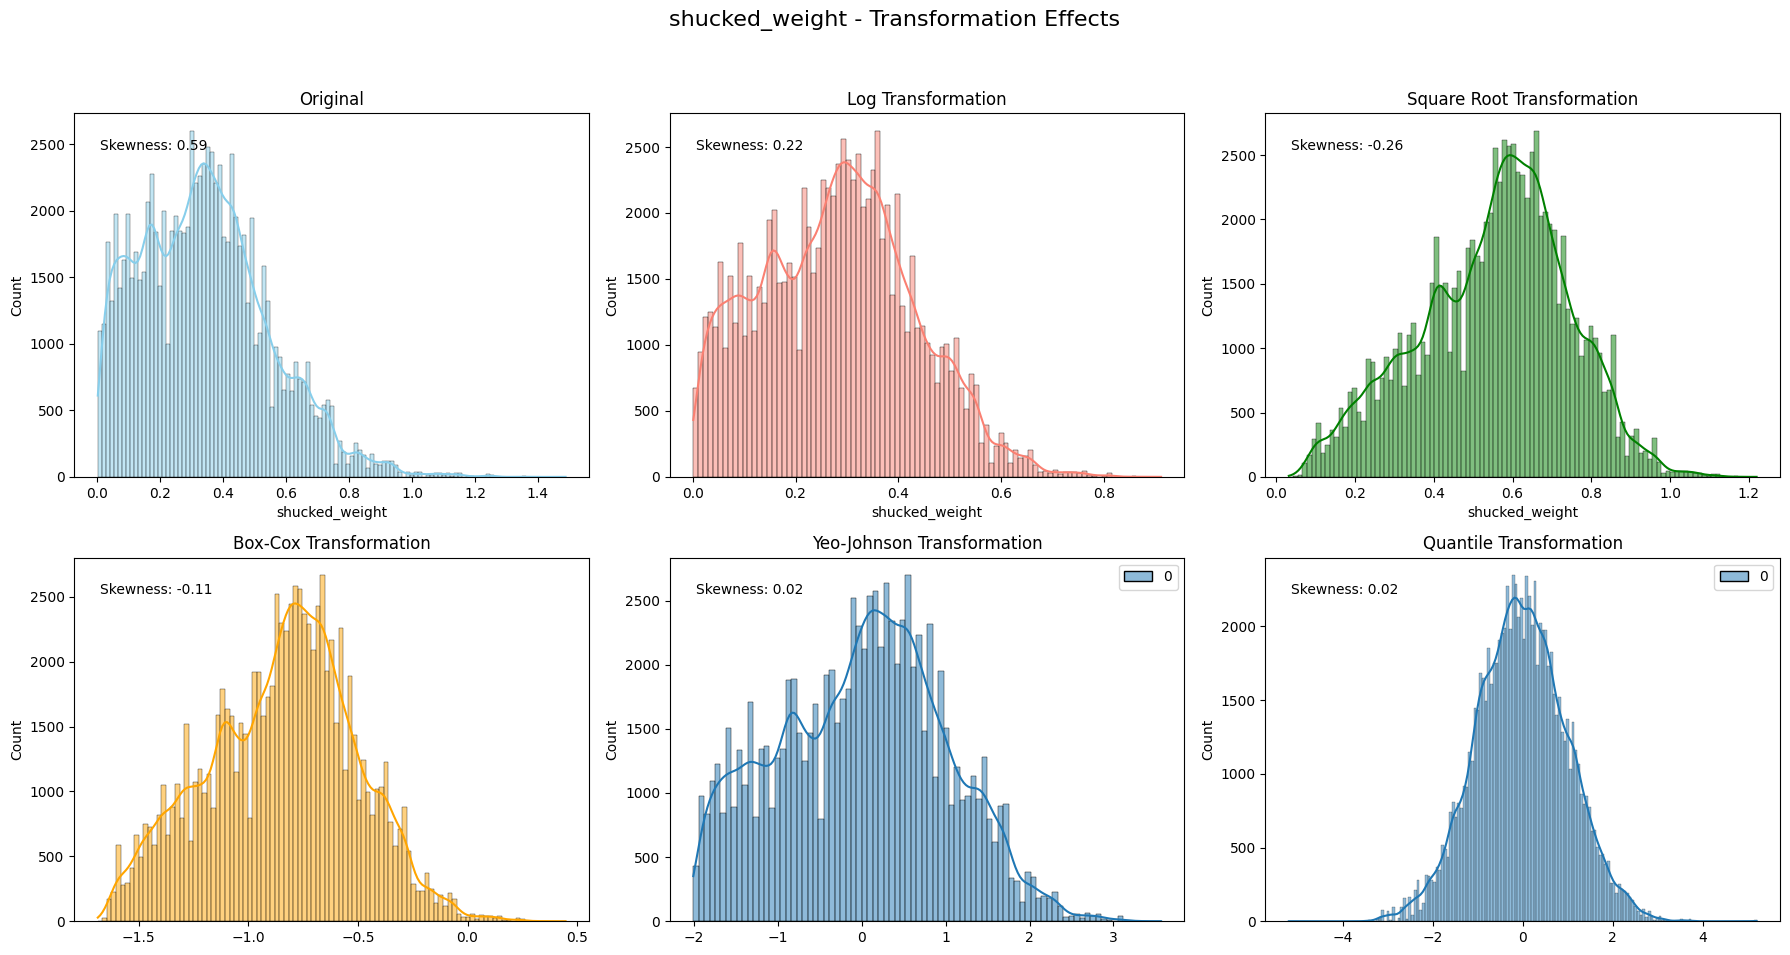

In [78]:
# Log Transformation, Square Root Transformation, Box-Cox Transformation, Yeo-Johnson Transformation, Quantile Transformation
def plot_positive_transformations(data, title, drop_cols=[]):
    """
    Test and plot the effect of various transformations for columns with positive skewness.

    Parameters:
    data (DataFrame): The DataFrame containing numerical columns.
    title (str): The title of the plot.
    drop_cols (list): A list of columns to exclude from transformation and plotting.

    Returns:
    None
    """
    # Select only numerical columns with positive skewness
    positive_skew_cols = data.select_dtypes(include=[np.number]).skew() > 0
    cols = positive_skew_cols[positive_skew_cols].index.tolist()
    cols = [col for col in cols if col not in drop_cols]

    for col in cols:
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        fig.suptitle(f"{col} - Transformation Effects", fontsize=16)

        # Original distribution
        sns.histplot(data[col], kde=True, ax=axes[0, 0], color='skyblue')
        axes[0, 0].set_title("Original")
        axes[0, 0].text(0.05, 0.9, f"Skewness: {data[col].skew():.2f}", transform=axes[0, 0].transAxes)

        # Log Transformation
        transformed_log = np.log1p(data[col])
        sns.histplot(transformed_log, kde=True, ax=axes[0, 1], color='salmon')
        axes[0, 1].set_title("Log Transformation")
        axes[0, 1].text(0.05, 0.9, f"Skewness: {transformed_log.skew():.2f}", transform=axes[0, 1].transAxes)

        # Square Root Transformation
        transformed_sqrt = np.sqrt(data[col])
        sns.histplot(transformed_sqrt, kde=True, ax=axes[0, 2], color='green')
        axes[0, 2].set_title("Square Root Transformation")
        axes[0, 2].text(0.05, 0.9, f"Skewness: {transformed_sqrt.skew():.2f}", transform=axes[0, 2].transAxes)

        # Box-Cox Transformation
        transformed_data_bc, _ = boxcox(data[col])
        sns.histplot(transformed_data_bc, kde=True, ax=axes[1, 0], color='orange')
        axes[1, 0].set_title("Box-Cox Transformation")
        axes[1, 0].text(0.05, 0.9, f"Skewness: {pd.Series(transformed_data_bc).skew():.2f}", transform=axes[1, 0].transAxes)

        # Yeo-Johnson Transformation
        pt = PowerTransformer(method='yeo-johnson')
        transformed_data_yj = pt.fit_transform(data[col].values.reshape(-1, 1))
        sns.histplot(transformed_data_yj, kde=True, ax=axes[1, 1], color='purple')
        axes[1, 1].set_title("Yeo-Johnson Transformation")
        axes[1, 1].text(0.05, 0.9, f"Skewness: {pd.Series(transformed_data_yj.flatten()).skew():.2f}", transform=axes[1, 1].transAxes)

        # Quantile Transformation
        qt = QuantileTransformer(output_distribution='normal')
        transformed_data_qt = qt.fit_transform(data[col].values.reshape(-1, 1))
        sns.histplot(transformed_data_qt, kde=True, ax=axes[1, 2], color='brown')
        axes[1, 2].set_title("Quantile Transformation")
        axes[1, 2].text(0.05, 0.9, f"Skewness: {pd.Series(transformed_data_qt.flatten()).skew():.2f}", transform=axes[1, 2].transAxes)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

# Example usage:
# Assuming 'df' is your DataFrame
plot_positive_transformations(train[cols_need_transform_positive.keys()], "Effect of Transformations", drop_cols=[])

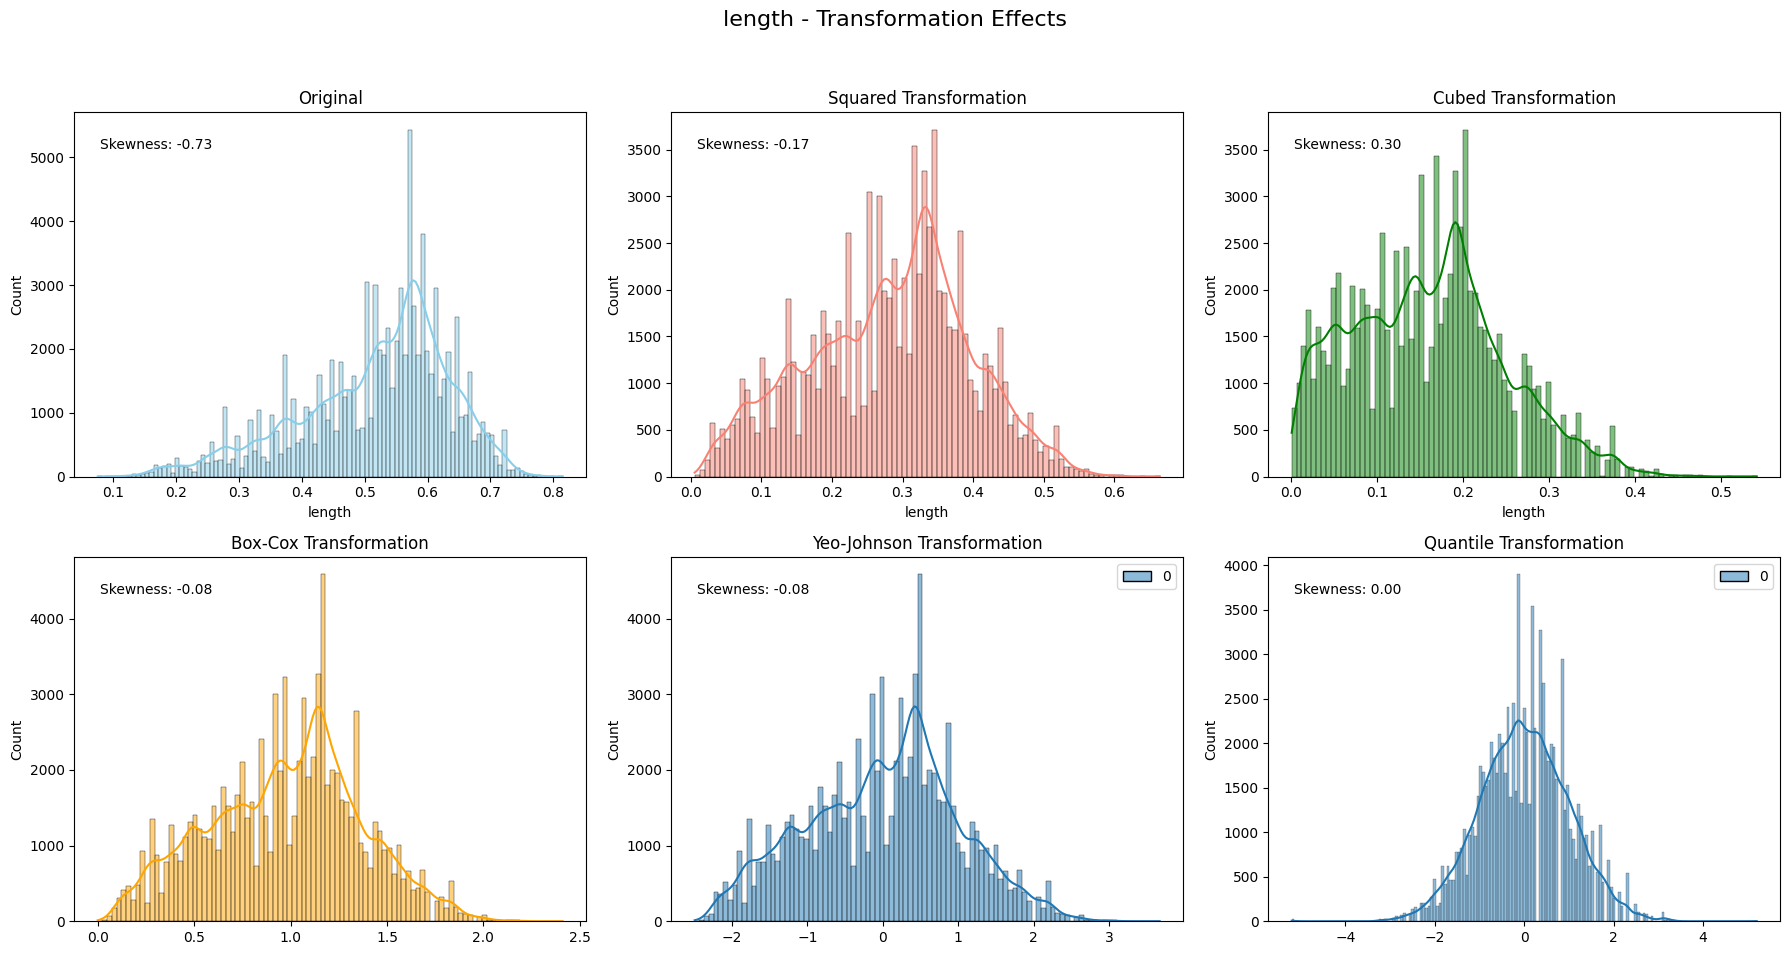

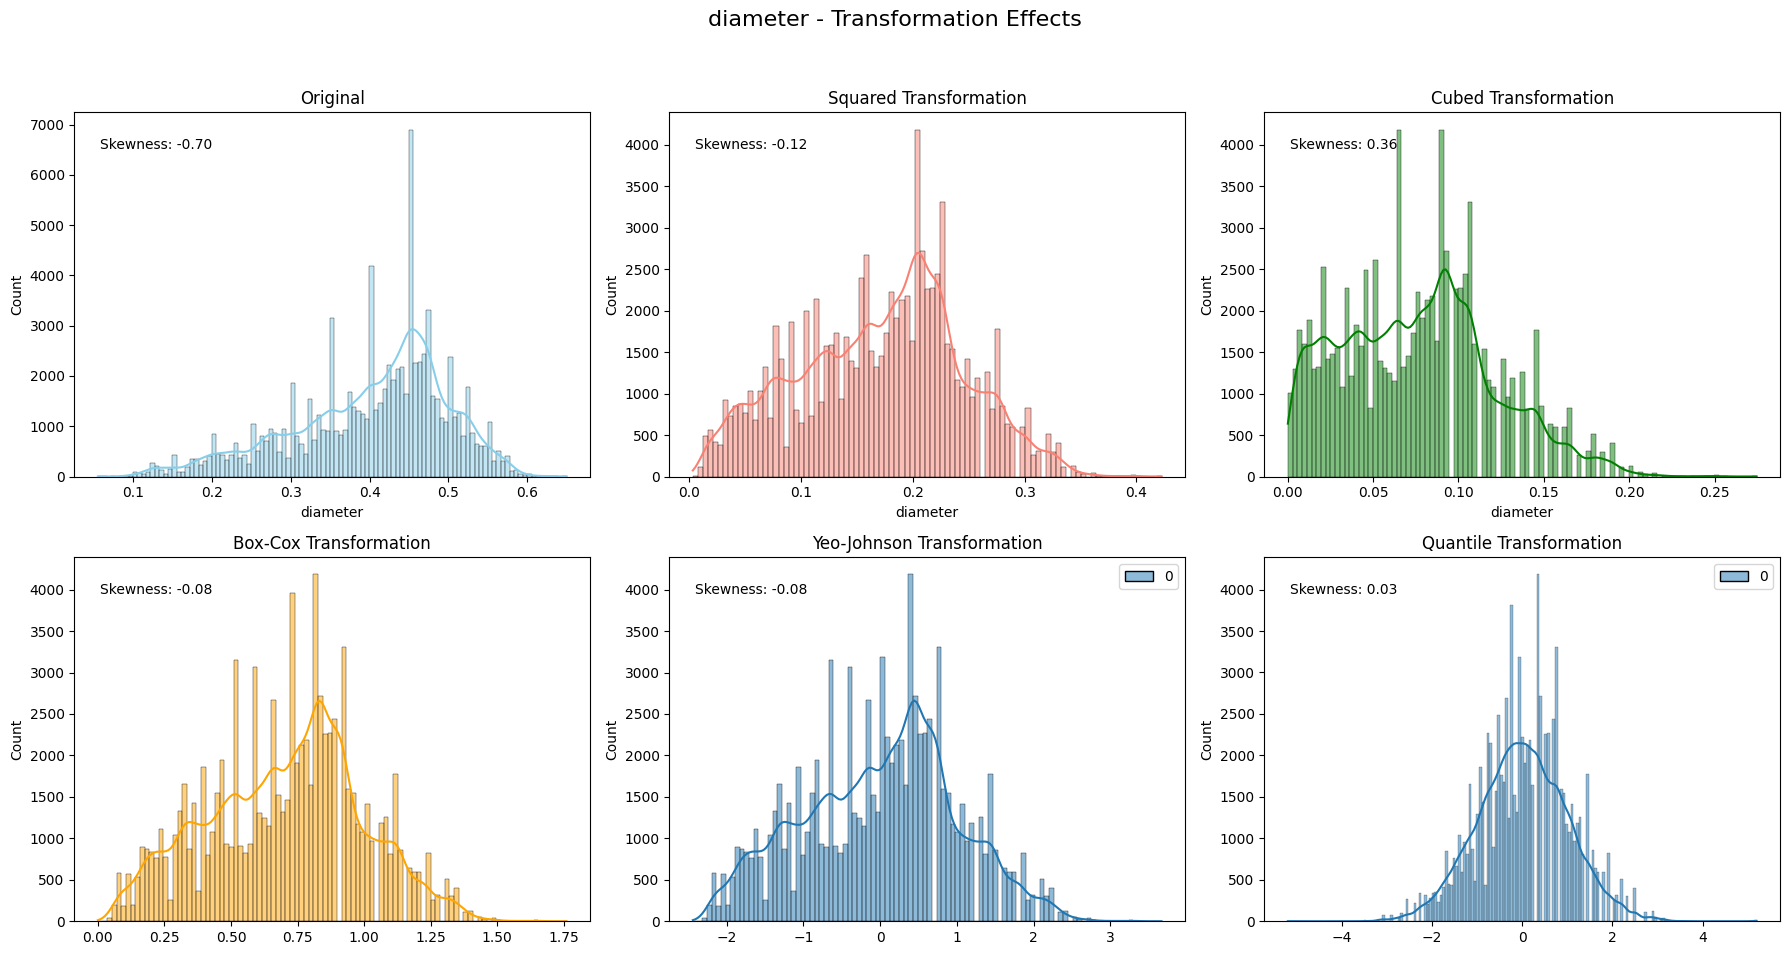

In [79]:
def plot_negative_transformations(data, title, drop_cols=[]):
    """
    Test and plot the effect of various transformations for columns with negative skewness.

    Parameters:
    data (DataFrame): The DataFrame containing numerical columns.
    title (str): The title of the plot.
    drop_cols (list): A list of columns to exclude from transformation and plotting.

    Returns:
    None
    """
    # Select only numerical columns with negative skewness
    negative_skew_cols = data.select_dtypes(include=[np.number]).skew() < 0
    cols = negative_skew_cols[negative_skew_cols].index.tolist()
    cols = [col for col in cols if col not in drop_cols]

    for col in cols:
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        fig.suptitle(f"{col} - Transformation Effects", fontsize=16)

        # Original distribution
        sns.histplot(data[col], kde=True, ax=axes[0, 0], color='skyblue')
        axes[0, 0].set_title("Original")
        axes[0, 0].text(0.05, 0.9, f"Skewness: {data[col].skew():.2f}", transform=axes[0, 0].transAxes)

        # Squared Transformation
        transformed_squared = data[col] ** 2
        sns.histplot(transformed_squared, kde=True, ax=axes[0, 1], color='salmon')
        axes[0, 1].set_title("Squared Transformation")
        axes[0, 1].text(0.05, 0.9, f"Skewness: {transformed_squared.skew():.2f}", transform=axes[0, 1].transAxes)

        # Cubed Transformation
        transformed_cubed = data[col] ** 3
        sns.histplot(transformed_cubed, kde=True, ax=axes[0, 2], color='green')
        axes[0, 2].set_title("Cubed Transformation")
        axes[0, 2].text(0.05, 0.9, f"Skewness: {transformed_cubed.skew():.2f}", transform=axes[0, 2].transAxes)

        # Box-Cox Transformation
        transformed_data_bc, _ = boxcox(data[col] - data[col].min() + 1)
        sns.histplot(transformed_data_bc, kde=True, ax=axes[1, 0], color='orange')
        axes[1, 0].set_title("Box-Cox Transformation")
        axes[1, 0].text(0.05, 0.9, f"Skewness: {pd.Series(transformed_data_bc).skew():.2f}", transform=axes[1, 0].transAxes)

        # Yeo-Johnson Transformation
        pt = PowerTransformer(method='yeo-johnson')
        transformed_data_yj = pt.fit_transform(data[col].values.reshape(-1, 1))
        sns.histplot(transformed_data_yj, kde=True, ax=axes[1, 1], color='purple')
        axes[1, 1].set_title("Yeo-Johnson Transformation")
        axes[1, 1].text(0.05, 0.9, f"Skewness: {pd.Series(transformed_data_yj.flatten()).skew():.2f}", transform=axes[1, 1].transAxes)

        # Quantile Transformation
        qt = QuantileTransformer(output_distribution='normal')
        transformed_data_qt = qt.fit_transform(data[col].values.reshape(-1, 1))
        sns.histplot(transformed_data_qt, kde=True, ax=axes[1, 2], color='brown')
        axes[1, 2].set_title("Quantile Transformation")
        axes[1, 2].text(0.05, 0.9, f"Skewness: {pd.Series(transformed_data_qt.flatten()).skew():.2f}", transform=axes[1, 2].transAxes)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

# Example usage:
# Assuming 'df' is your DataFrame
plot_negative_transformations(train[cols_need_transform_negative.keys()], "Effect of Transformations", drop_cols=[])

In [84]:
# Define transformations_positive
transformations_positive = {
    "Log_ShuckedWeight": np.log1p(train["shucked_weight"]),
    "Sqrt_ShuckedWeight": np.sqrt(train["shucked_weight"]),
    "BoxCox_ShuckedWeight": boxcox(train["shucked_weight"])[0],
    "YeoJohnson_ShuckedWeight": yeojohnson(train["shucked_weight"])[0],
    "Quantile_ShuckedWeight": QuantileTransformer(output_distribution='normal').fit_transform(train["shucked_weight"].values.reshape(-1, 1)).flatten()
}

# Standardizing the transformations_positive before performing KS test
ks_test_results = {}
for transformation, data in transformations_positive.items():
    standardized_data = (data - data.mean()) / data.std()
    ks_stat, ks_p_value = kstest(standardized_data, 'norm')
    ks_test_results[transformation] = (ks_stat, ks_p_value.round(5))

# Convert results to DataFrame for easier comparison
ks_test_results_df = pd.DataFrame.from_dict(ks_test_results, orient='index', columns=['KS Statistic', 'P-Value'])
print(ks_test_results_df)
            

                          KS Statistic  P-Value
Log_ShuckedWeight             0.037065  0.00000
Sqrt_ShuckedWeight            0.052515  0.00000
BoxCox_ShuckedWeight          0.040857  0.00000
YeoJohnson_ShuckedWeight      0.035647  0.00000
Quantile_ShuckedWeight        0.006693  0.00059


In [91]:
transformations_negative = {
    "Log_Diameter": np.log1p(train["diameter"]),
    "Sqrt_Diameter": np.sqrt(train["diameter"]),
    "BoxCox_Diameter": boxcox(train["diameter"])[0],
    "YeoJohnson_Diameter": yeojohnson(train["diameter"])[0],
    "Quantile_Diameter": QuantileTransformer(output_distribution='normal').fit_transform(train["diameter"].values.reshape(-1, 1)).flatten(),
    "Log_Length": np.log1p(train["length"]),
    "Sqrt_Length": np.sqrt(train["length"]),
    "BoxCox_Length": boxcox(train["length"])[0],
    "YeoJohnson_Length": yeojohnson(train["length"])[0],
    "Quantile_Length": QuantileTransformer(output_distribution='normal').fit_transform(train["length"].values.reshape(-1, 1)).flatten()
}

# Standardizing the transformations before performing KS test
ks_test_results = {}
for transformation, data in transformations_negative.items():
    standardized_data = (data - data.mean()) / data.std()
    ks_stat, ks_p_value = kstest(standardized_data, 'norm')
    ks_test_results[transformation] = (ks_stat, ks_p_value.round(5))

# Convert results to DataFrame for easier comparison
ks_test_results_df = pd.DataFrame.from_dict(ks_test_results, orient='index', columns=['KS Statistic', 'P-Value'])
print(ks_test_results_df)

                     KS Statistic  P-Value
Log_Diameter             0.109764      0.0
Sqrt_Diameter            0.121352      0.0
BoxCox_Diameter          0.063157      0.0
YeoJohnson_Diameter      0.055899      0.0
Quantile_Diameter        0.024815      0.0
Log_Length               0.110960      0.0
Sqrt_Length              0.120108      0.0
BoxCox_Length            0.058519      0.0
YeoJohnson_Length        0.051574      0.0
Quantile_Length          0.022673      0.0


<div style="background-color: #343A1A; padding: 10px; border: 1px solid #ccc; border-radius: 5px;">

**Notes**

<p>Visual Inspection Conclusions</p>
<ul>
    <li><b>sqrt:</b> ['length', 'diameter', 'height', 'whole_weight', 'shucked_weight',
       'viscera_weight', 'shell_weight', 'rings', 'length_diameter_ratio',
       'height_diameter_ratio', 'volume', 'shell_thickness_to_length',
       'shell_thickness_to_diameter']</li>
    <li><b>yeo</b> ['length', 'diameter', 'height']</li>
<ul>

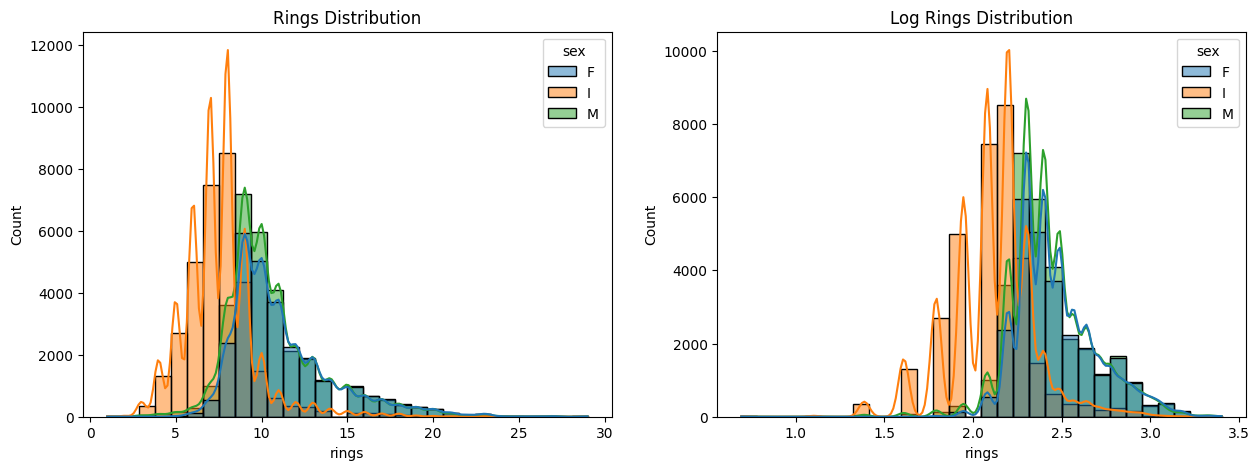

In [21]:
# Target variable distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=train, x='rings', kde=True, bins=30,hue='sex',ax=axes[0])
sns.histplot(data=train, x=np.log1p(train['rings']), kde=True, bins=30,hue='sex', ax=axes[1])
axes[0].set_title('Rings Distribution')
axes[1].set_title('Log Rings Distribution')
plt.show()

<div style="background-color: #343A1A; padding: 10px; border: 1px solid #ccc; border-radius: 5px;">

**Notes**
<ul>
    <li>
        <p>Initially target distribution is skewed, with sqrt transformation looks better</p>
    </li>
</ul>
</div>

### PairPlot

In [22]:
#sns.pairplot(data=train, vars=numeric_cols, hue='sex', diag_kind='kde', corner=True);

<div style="background-color: #343A1A; padding: 10px; border: 1px solid #ccc; border-radius: 5px;">

<p>Inferences</p>

<ol>
<li>There is a bit diference between an infant and adult Abalone</li>
<li>
<p>Linear relations:</p>
<ul>length vs diameter - (+++)  - </ul>
<ul>height vs length and diameter - (+) </ul>
<ul>between weights - (+++) with dispersion </ul>
<li>
<p>Polinomial relations</p>
<ul>all weights vs length - poly2, exp</ul>
<ul>all weights vs diameter - pol2, exp </ul>
</li>
<li>Sex is an important feature to destinguist between infant and adult</li>
<ol>

<div>

# 3 - Pipelines

In [23]:
train[numeric_cols_without_target].columns

Index(['length', 'diameter', 'height', 'whole_weight', 'shucked_weight',
       'viscera_weight', 'shell_weight', 'length_diameter_ratio',
       'height_diameter_ratio', 'volume', 'shell_thickness_to_length',
       'shell_thickness_to_diameter'],
      dtype='object')

In [92]:
train[numeric_cols_without_target]

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight
id,,,,,,,
0,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400
1,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200
2,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050
3,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500
4,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975
...,...,...,...,...,...,...,...
90610,0.335,0.235,0.075,0.1585,0.0685,0.0370,0.0450
90611,0.555,0.425,0.150,0.8790,0.3865,0.1815,0.2400
90612,0.435,0.330,0.095,0.3215,0.1510,0.0785,0.0815


In [94]:

normal_columns = ['height', 'whole_weight', 'viscera_weight', 'shell_weight']
quantile_transformation = ['shucked_weight', 'diameter', 'length']
cat_colums = ['sex']

X = train.drop(columns='rings')
y = train['rings']


quantile__transformer = Pipeline(steps=[
    ('quantile', QuantileTransformer(output_distribution='normal')),
    ('scaler', StandardScaler())
    ])

    

preprocessor = ColumnTransformer(
    transformers=[
        ('num_normal', StandardScaler(), normal_columns),
        ('num_quantile', quantile__transformer, quantile_transformation),
        ('encoder_sex', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ])

# Define target transformer
target_transformer = TransformedTargetRegressor(regressor=LGBMRegressor(force_col_wise=True, random_state=SEED),
                                                func=np.sqrt, 
                                                inverse_func=np.square)

# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', target_transformer)  # Add your model after feature selection
])

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_normal',
                                                  StandardScaler(),
                                                  ['height', 'whole_weight',
                                                   'viscera_weight',
                                                   'shell_weight']),
                                                 ('num_quantile',
                                                  Pipeline(steps=[('quantile',
                                                                   QuantileTransformer(output_distribution='normal')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['shucked_weight', 'diameter',
                                                   'length']),
                                                 ('encoder_sex',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['sex'])])),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'sqrt'>,
                                            inverse_func=<ufunc 'square'>,
                                            regressor=LGBMRegressor(force_col_wise=True,
                                                                    random_state=42)))])

In [95]:
def objective(trial):
    
   # Define the hyperparameters to optimize
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'max_depth': trial.suggest_int('max_depth', 1, 8),
        'learning_rate' : trial.suggest_float('learning_rate',0.01,1, log=True),
        'n_estimators' : trial.suggest_int('n_estimators',10,10000),
        'objective': 'regression',
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 0.1),
        'min_child_weight': trial.suggest_float('min_child_weight', 0, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 20),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 10),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 0.1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 0.1),
        'importance_type': 'gain'   
    }
   
    # Initialize LightGBM model with suggested hyperparameters 
    target_transformer = TransformedTargetRegressor(regressor=LGBMRegressor(**params,
                                                                            force_col_wise=True, 
                                                                            random_state=SEED),
                                                    func=np.sqrt, 
                                                    inverse_func=np.square)



    # Create a pipeline with preprocessing and XGBoost model
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', target_transformer)
    ])

    cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

    # Calculate the cross-validated negative RMSLE score
    scores = -1 * cross_val_score(pipeline,
                                    X,
                                    y,
                                    cv=cv,
                                    scoring='neg_root_mean_squared_log_error',
                                    n_jobs=-1)

    return scores.mean()

In [96]:
%%time

# # perform hyperparameter optimization with Optuna
study = optuna.create_study(direction='minimize', study_name='lightGBM_feature_scaling_transformation_quantile')
study.optimize(objective, n_trials=100)

print('\n----------------------------------------\n')
print(f'Best trial: {study.best_trial.params}')
print(f'Best score: {study.best_value}')

[I 2024-04-15 22:14:52,474] A new study created in memory with name: lightGBM_feature_scaling_transformation_quantile
[I 2024-04-15 22:15:21,167] Trial 0 finished with value: 0.14946038476058593 and parameters: {'num_leaves': 85, 'max_depth': 3, 'learning_rate': 0.05139738425908256, 'n_estimators': 6127, 'min_gain_to_split': 0.03678072575017828, 'min_child_weight': 9.723880833716557, 'min_child_samples': 10, 'subsample': 0.5958847629969117, 'subsample_freq': 5, 'colsample_bytree': 0.9950901331742116, 'reg_alpha': 0.06651271399037788, 'reg_lambda': 0.08128166393860249}. Best is trial 0 with value: 0.14946038476058593.
[I 2024-04-15 22:15:55,634] Trial 1 finished with value: 0.16451032220637868 and parameters: {'num_leaves': 152, 'max_depth': 3, 'learning_rate': 0.5868221203223057, 'n_estimators': 7453, 'min_gain_to_split': 0.004640766807522157, 'min_child_weight': 0.6763340706421139, 'min_child_samples': 16, 'subsample': 0.7378263502410098, 'subsample_freq': 7, 'colsample_bytree': 0.640


----------------------------------------

Best trial: {'num_leaves': 101, 'max_depth': 8, 'learning_rate': 0.011218113169254137, 'n_estimators': 8307, 'min_gain_to_split': 0.08798188951257872, 'min_child_weight': 0.007590040251383656, 'min_child_samples': 17, 'subsample': 0.6299421817697112, 'subsample_freq': 5, 'colsample_bytree': 0.5525715864604104, 'reg_alpha': 0.0716906980728527, 'reg_lambda': 0.056236960734656075}
Best score: 0.14823056301629867
CPU times: total: 16 s
Wall time: 54min 55s


In [97]:
best_params = study.best_trial.params

best_params

{'num_leaves': 101,
 'max_depth': 8,
 'learning_rate': 0.011218113169254137,
 'n_estimators': 8307,
 'min_gain_to_split': 0.08798188951257872,
 'min_child_weight': 0.007590040251383656,
 'min_child_samples': 17,
 'subsample': 0.6299421817697112,
 'subsample_freq': 5,
 'colsample_bytree': 0.5525715864604104,
 'reg_alpha': 0.0716906980728527,
 'reg_lambda': 0.056236960734656075}

In [98]:
best_paramns_lgbm = {'num_leaves': 101,
 'max_depth': 8,
 'learning_rate': 0.011218113169254137,
 'n_estimators': 8307,
 'min_gain_to_split': 0.08798188951257872,
 'min_child_weight': 0.007590040251383656,
 'min_child_samples': 17,
 'subsample': 0.6299421817697112,
 'subsample_freq': 5,
 'colsample_bytree': 0.5525715864604104,
 'reg_alpha': 0.0716906980728527,
 'reg_lambda': 0.056236960734656075}

In [99]:
# Initialize XGBoost model with best hyperparameters
model_LightGBM_tunned = LGBMRegressor(**best_paramns_lgbm,force_col_wise=True, random_state=SEED)

#fit the model
pipe_lgbm_tunned = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model_LightGBM_tunned)
])

pipe_lgbm_tunned.fit(X, y)

[LightGBM] [Warning] min_gain_to_split is set=0.08798188951257872, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08798188951257872
[LightGBM] [Warning] min_gain_to_split is set=0.08798188951257872, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08798188951257872
[LightGBM] [Info] Total Bins 1328
[LightGBM] [Info] Number of data points in the train set: 90615, number of used features: 9
[LightGBM] [Info] Start training from score 9.696794


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_normal',
                                                  StandardScaler(),
                                                  ['height', 'whole_weight',
                                                   'viscera_weight',
                                                   'shell_weight']),
                                                 ('num_quantile',
                                                  Pipeline(steps=[('quantile',
                                                                   QuantileTransformer(output_distribution='normal')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['shucked_weight', 'diameter',
                                                   'length']),
                                                 ('encoder_sex',
                                                  OneHotEncoder(dr...
                 LGBMRegressor(colsample_bytree=0.5525715864604104,
                               force_col_wise=True,
                               learning_rate=0.011218113169254137, max_depth=8,
                               min_child_samples=17,
                               min_child_weight=0.007590040251383656,
                               min_gain_to_split=0.08798188951257872,
                               n_estimators=8307, num_leaves=101,
                               random_state=42, reg_alpha=0.0716906980728527,
                               reg_lambda=0.056236960734656075,
                               subsample=0.6299421817697112,
                               subsample_freq=5))])

In [101]:
# transform the test data 
joblib.dump(pipe_lgbm_tunned, 'models/lgbm_tunned_no_extra_feature_best_transformations.pkl')

['models/lgbm_tunned_no_extra_feature_best_transformations.pkl']

# Predictions

In [102]:
#load the model
model = joblib.load('models/lgbm_tunned_no_extra_feature_best_transformations.pkl')

# predict on test data
y_pred = model.predict(test)

y_pred[:10]                       

[LightGBM] [Warning] min_gain_to_split is set=0.08798188951257872, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08798188951257872


array([10.08665051,  9.8890586 ,  9.69496161, 10.32715905,  7.73304435,
        9.62632601, 10.76139481,  6.13381574,  7.94167872, 10.83056896])

In [103]:
# Create a DataFrame for the submission data
submission_data = pd.DataFrame(y_pred, index=test.index, columns=['rings'])

submission_data

,rings
id,
90615,10.086651
90616,9.889059
90617,9.694962
90618,10.327159
90619,7.733044
...,...
151021,6.445657
151022,9.364346
151023,13.160169


In [104]:
# Save the DataFrame to a CSV file

submission_data
submission_data.to_csv('outputs/submission_lgbm_noextra_best_transformations.csv')

kagge public result was: `0.14873` - worst

# stuff to do

- optimize for catboost
- voting
- emsemble
- add more features
- conversion to log(y)